Hello AtomDB!
=============================

This tutorial shows how to use QC-AtomDB as a Python library.


Learning outcomes
-----------------

- Loading/Dumping atomic species data

- Getting atomic properties

- Defining a pormolecule and evalauting its properties

### Packages isntall for Google Colab

In [1]:
! pip install git+https://github.com/theochem/iodata.git
! pip install git+https://github.com/theochem/grid.git
! pip install git+https://github.com/theochem/denspart.git
! pip install git+https://github.com/theochem/AtomDB.git@demo_notebook

In [2]:
# download the example files
import os
from urllib.request import urlretrieve

fpath = "data/"
if not os.path.exists(fpath):
    os.makedirs(fpath, exist_ok=True)

urlretrieve(
    "https://raw.githubusercontent.com/theochem/AtomDB/demo_notebook/doc/notebooks/data/dichloropyridine26.fchk",
    os.path.join(fpath, "dichloropyridine26.fchk")
    )

urlretrieve(
    "https://raw.githubusercontent.com/theochem/AtomDB/demo_notebook/doc/notebooks/data/dichloropyridine26_mbis.npz",
    os.path.join(fpath, "dichloropyridine26_mbis.npz")
    )

In [3]:
# import sys  
# sys.path.insert(0, '../../')

<!-- Atom-DB as a Python library
---------------------------- -->

The following lines should appear at the beginning of the scripts:

In [4]:
# Import the AtomDB library
import atomdb

# Optional modules
import numpy as np
from matplotlib import pyplot


### Loading/Dumping Data

Use the `atomdb.load` function to retrieve an atomic spcies' information.

The required inputs are: element symbol, charge and multiplicity. 

Optionally a dataset name can be specified choosing one of:

- `nist`: NIST spectroscopic data complemented with results from [Phys. Chem. Chem. Phys., 2016,18, 25721-25734](https://doi.org/10.1039/C6CP04533B)

- `slater`: Atomic orbitals and electronic denisty properties from SCF calculations using Slater basis.

- `numeric`: electronic denisty properties from numerical Hartree-fock calculations.

- `gaussian`: Atomic orbitals and electronic denisty properties from SCF calculations using gaussian basis. 

Currently we only support neutral/charged elements in its ground state, therefore, the optional parameter nexc (electronic state number) is not specified, leaving it to take its dafault value 0.

In [5]:
# Define species and load data
element = 'Cl'
charge = 0
mult = 2
dataset = 'slater'

chl = atomdb.load(element, charge, mult, dataset=dataset)



All information stored about a specise can be outputted in a JSON file format using:

In [6]:
# Dumping Data to a JSON File
# chl.to_json()

### Getting Atomic Properties

Bellow we showcase some of the accesible scalar and vector properties (mostly related to the electron density)
 
Note that we use dictionaries for properties like the non-bonded atomic radius having more than one definition.

* Scalars

In [7]:
print("Atomic number: ", chl.natom)
print("Number of electrons: ", chl.nelec)
print("Mass [a.u.]: ", chl.mass)
print("Atomic radius [a.u.]: ", chl.vdw_radii['bondi'])

Atomic number:  17
Number of electrons:  17
Mass [a.u.]:  35.4515
Atomic radius [a.u.]:  3.307020734362191


* Vectors

In [8]:
# Atomic orbitals
print("Number of spin-orbitals (alpha): ", chl.ao.norba)
print("Energies: ", chl.ao.energy_a)
print("Occupations (alpha): ", chl.ao.occs_a)
print("Occupations (beta): ", chl.ao.occs_b)

Number of spin-orbitals (alpha):  5
Energies:  [-104.8844208  -10.6074807   -1.0729121   -8.0722274   -0.5063999]
Occupations (alpha):  [1. 1. 1. 3. 3.]
Occupations (beta):  [1. 1. 1. 3. 2.]


* Functions (electron density properties)

Two methods are available to compute density-related properties: `interpolate_dens` and `interpolate_ked`; they return spline functions (cubic splines) that can be evaluated on a radial grid. 

<!-- Optionally, one can select the type of orbitals included in the calculation and take a subset of them by specifying their spin component and index, respectively (by default, all occupied alpha and beta spin-orbitals are included, `spin=ab` and `index=None`). Also, density derivatives are accessible through the `deriv` parameter passed to the splines. -->

In [9]:
# Define a uniform radial grid and evaluate density
rad_grid = np.linspace(0., 6., num=100)
dens_spline = chl.interpolate_dens(log=True)

dens = dens_spline(rad_grid)

Text(0.5, 0.98, 'Spherically averaged density')

<Figure size 2400x1800 with 0 Axes>

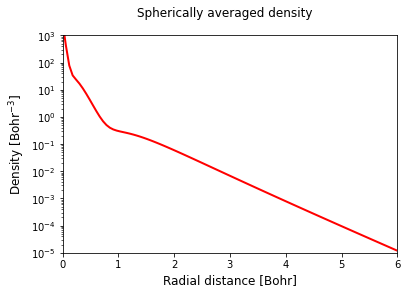

In [10]:
pyplot.figure(figsize = (8, 6), dpi=300)

# pyplot.rcParams.update({'font.size': 16})
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 12,
         'axes.titlesize':16,
         'xtick.labelsize':10,
         'ytick.labelsize':10}
pyplot.rcParams.update(params)


fig, ax = pyplot.subplots()

ax.plot(rad_grid, dens, '-r', linewidth=2)

ax.set(xlabel="Radial distance [Bohr]", ylabel="Density [Bohr$^{-3}$]")
ax.set_yscale('log')
ax.set_ylim(top=1000, bottom=0.00001)
ax.set_xlim(left=0., right=6)
fig.suptitle(f'Spherically averaged density')

## Promolecule tool: making a pormolecule and evalauting its properties

![2,4,6-Trinitrotoluene](images/dichlp_rdkit.png)

The tool function `make_promolecule` in the `promolecule` module will build a promolecule for us. It is as simple as providing the list of atomic numbers and coordinates defining the molecule.

In [11]:
# Import modules
from atomdb.promolecule import make_promolecule

# optional modules
from iodata import load_one, dump_one
from iodata.utils import Cube
from grid.cubic import UniformGrid

In [12]:
# Define the molecule (atoms and coordinates)
fname = 'dichloropyridine26'
mol = load_one(f'data/{fname}.fchk')
atnums = mol.atnums
atcoords = mol.atcoords

# Build de promolecule
promol = make_promolecule(atnums, atcoords, dataset='slater')

print("Atomic mass: ", promol.mass())
print("Electronic energy: ", -promol.energy())

Atomic mass:  147.98677999999998
Electronic energy:  -1163.308173596


The promolecule's electron density is evaluated with the method `density`. In this example we use [Grid](https://github.com/theochem/grid) package to generate the required input set of points, but any external package with the same capabilities could be used.

In [13]:
# Generate a grid
cubgrid = UniformGrid.from_molecule(mol.atnums, atcoords, spacing=0.2, extension=5.0, rotate=False, weight="Trapezoid")

# Evaluate the pormolecule's density
promol_dens = promol.density(cubgrid.points)

In [14]:
# Using IOData we can write the densities to a Gaussian Cube file
data = promol_dens.reshape(cubgrid.shape)
axes = cubgrid.axes
origin = cubgrid.origin

iocube = Cube(origin, axes, data)
mol.cube = iocube
dump_one(mol, f'data/{fname}_rho.cube')

Optionally, we can build on top of the previous example, and evaluate the electrostatic potential of the molecule to map it on the promolecule density isosurface.

The necessary atomic charges can be computed with DensPart implementation of Minimal Basis Iterative Stockholder (MBIS) scheme (see [instructions](https://github.com/theochem/denspart)).

#### Evaluating the electrostatic potential

In [15]:
# MBIS charges from DensPart
dichlorop = np.load(f'data/{fname}_mbis.npz')
charges = dichlorop['charges']

# Electrostatic potential
f = lambda q, radii : q / radii
esp = sum(f(q, np.linalg.norm(cubgrid.points - coord, axis=1)) for (q, coord) in zip(charges, promol.coords))


# Write data to cube file
data = esp.reshape(cubgrid.shape)
axes = cubgrid.axes
origin = cubgrid.origin

iocube = Cube(origin, axes, data)
mol.cube = iocube
dump_one(mol, f'data/{fname}_pot.cube')

The final electrostatic surface potential (ESP) visualized with [UCSF ChimeraX](https://www.cgl.ucsf.edu/chimerax/) GUI is displayed bellow. 

(The promolecule density isosurface corresponds to a value of 0.002)

![2,4,6-Trinitrotoluene](images/dclp_esp_slater.jpg)